In [1]:
from pytfa.io.json import load_json_model
from cobra import Reaction

redgem_file_name = 'reduced_model_ETC_core_20240816-155234.json'

# New model with changed nadh 
redgem_file_name = 'reduced_model_ETC_core_20250228-213124.json'

reduced_model = load_json_model(redgem_file_name)
reduced_model.optimize()

# remove sinks if there are still any
reduced_model.remove_reactions([rxn.id for rxn in reduced_model.reactions if 'sink' in rxn.id])

# Thermo for sodium
reduced_model.thermo_data['metabolites']['cpd00971']['deltaGf_std'] = 1.0
reduced_model.thermo_data['metabolites']['cpd00971']['deltaGf_err'] = 0.1
reduced_model.thermo_data['metabolites']['cpd00971']['error']  = 'Nil'


2025-03-04 11:40:20,630 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [2]:
# Resting membrane potential
reduced_model.compartments['c']['membranePot']['e'] = 60
reduced_model.compartments['e']['membranePot']['c'] = -60
# Resting mitochondrial membrane potential
reduced_model.compartments['m']['membranePot']['c'] = 150
reduced_model.compartments['c']['membranePot']['m'] = -150


In [3]:
reduced_model.compartments['m']['pH'], reduced_model.compartments['c']['pH']

(8.0, 7.2)

In [4]:
# Change h_i to h_c

for reactions in reduced_model.metabolites.h_i.reactions:
    h_i_stoichiometry = reactions.metabolites[reduced_model.metabolites.h_i]
    reactions.add_metabolites({reduced_model.metabolites.h_c: h_i_stoichiometry})
    reactions.add_metabolites({reduced_model.metabolites.h_i: -h_i_stoichiometry})

In [5]:
###########################################################################
# Looks like we don't need to add a counter ion
###########################################################################

# from cobra import Metabolite

# # Add mitochondrial counter ino
# c_m = Metabolite('c1_m')
# c_m.charge = 1
# c_m.compartment = 'm'

# c_m.formula = 'Na'
# c_m.name = 'Counter ion'
# c_m.annotation['seed_id'] = 'cpd00971'

# # Add cytoplasmic counter ion
# c_c = Metabolite('c1_c')
# c_c.charge = 1
# c_c.compartment = 'c'

# c_c.formula = 'Na'
# c_c.name = 'Counter ion'
# c_c.annotation['seed_id'] = 'cpd00971'

# # No pKa for sodium
# reduced_model.thermo_data['metabolites']['cpd00971']['pKa']  = []

# # Add counterions to the model
# reduced_model.add_metabolites([c_m, c_c])

# #########################################################################
# # THIS IS A MAJOT PREDICTOION BASED ON MODELING 
# #########################################################################

# # To achive mitochondrial charge balance we a polarizing transport system
# pol_antiport = Reaction('pol_antiport')
# reduced_model.add_reactions([ pol_antiport,])
# pol_antiport.reaction = '2 c1_m + h_c <=> 2 c1_c + h_m'

# # Add a dissipation channel 
# # This is simplfied model for a charge neutral import of the counter ions 
# # By symport with netgative charges or antiport with positive charges
# diss_import = Reaction('diss_import')
# reduced_model.add_reactions([ diss_import,])
# diss_import.reaction = 'c1_c <=> c1_m'

In [6]:
from cobra import Metabolite

# Model glycogen synthesis and degradation
glycogen = Metabolite('glycogen_c')
glycogen.compartment = 'c'
glycogen.formula = 'C6H12O6' # glucose equivalent
glycogen.charge = 0
reduced_model.add_metabolites([glycogen,])



glycogen_synthesis = Reaction('glycogen_synthesis')
reduced_model.add_reactions([glycogen_synthesis,])
# USE ATP and G6P to make glycogen and release AMP and PPI 
glycogen_synthesis.reaction = 'atp_c + g6p_c -> glycogen_c + adp_c + 2 pi_c + h_c'
glycogen_synthesis.lower_bound = 1e-3

glycogen_degradation = Reaction('glycogen_degradation')
reduced_model.add_reactions([glycogen_degradation,])
# USE glycogen and release G6P
glycogen_degradation.reaction = 'glycogen_c + pi_c -> g6p_c'

# Add glycogen EX change reaction
glycogen_exchange = Reaction('EX_glycogen_c')
reduced_model.add_reactions([glycogen_exchange,])
glycogen_exchange.reaction = 'glycogen_c <=>'


reduced_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-1.00000,None
ACONTm,13.81250,None
AKGDm,13.81250,None
AKGMALtm,3.81250,None
ASPGLUm,3.81250,None
...,...,...
cyt_atp2adp,200.00000,None
PiC,200.00000,None
glycogen_synthesis,1.21875,None
glycogen_degradation,1.62500,None


In [7]:
# Remove constraints of type ModelConstraints 
from tqdm import tqdm

cons_subclass = reduced_model._cons_kinds['ModelConstraint']
for cons in tqdm(cons_subclass):
    reduced_model.remove_constraint(cons)


reduced_model.repair()

#### Prepare and convert model
reduced_model.prepare()
reduced_model.convert()

100%|██████████| 5/5 [00:00<00:00, 2424.73it/s]
2025-03-04 11:40:20,955 - thermomodel_Recon3thermoCurated - INFO - # Model preparation starting...
2025-03-04 11:40:20,965 - thermomodel_Recon3thermoCurated - INFO - # Model preparation done.
2025-03-04 11:40:20,966 - thermomodel_Recon3thermoCurated - INFO - # Model conversion starting...
2025-03-04 11:40:21,107 - thermomodel_Recon3thermoCurated - INFO - # Model conversion done.
2025-03-04 11:40:21,108 - thermomodel_Recon3thermoCurated - INFO - # Updating cobra_model variables...
2025-03-04 11:40:21,110 - thermomodel_Recon3thermoCurated - INFO - # cobra_model variables are up-to-date


In [8]:
# Balance this reaction correctly the extra proton should appear in mitochondria not be transported to the cytoplasm
reduced_model.reactions.NADH2_u10mi.add_metabolites({reduced_model.metabolites.h_c: -1})
reduced_model.reactions.NADH2_u10mi.add_metabolites({reduced_model.metabolites.h_m: 1})

In [9]:
# ATP synthase should transport 3 proton from the intermembrane space to the instead of 4 
reduced_model.reactions.ATPS4mi.add_metabolites({reduced_model.metabolites.h_c: 1})
reduced_model.reactions.ATPS4mi.add_metabolites({reduced_model.metabolites.h_m: -1})

# These protons are part of the PiC transport
reduced_model.reactions.PiC.add_metabolites({reduced_model.metabolites.h_c: -1})
reduced_model.reactions.PiC.add_metabolites({reduced_model.metabolites.h_m: 1})

In [10]:
reduced_model.reactions.NADH2_u10mi

Reaction identifier,NADH2_u10mi
Name,NADH2_u10mi
Memory address,0x07f7db8620c70
Stoichiometry,5.0 h_m + nadh_m + q10_m --> 4.0 h_c + nad_m + q10h2_m 5.0 Proton + Nicotinamide Adenine Dinucleotide - Reduced + Ubiquinone-10 --> 4.0 Proton + Nicotinamide Adenine Dinucleotide + Ubiquinol-10
GPR,(4715.1 and 4720.1 and 4719.1 and 4700.1 and 55967.1 and 4709.1 and 4710.1 and 4726.1 and 4718.1...
Lower bound,0.0
Upper bound,200.0


In [11]:
# Refine Glycolysis corrected delta G constraints from Lehninger:
# Units are in kJ/mol
glycolysis_thermodynamics = {
    'HEX1': -16.7,
    'PGI': 1.7,
    'PFK': -14.9,
    'FBA': 23.8,
    'TPI': 5.6, # Equilibrator value
    'GAPD': 6.3,
    'PGK': 18.8,
    'PGM': 4.4, 
    'ENO': 7.5,
    'PYK': -31.4,
    'LDH_L': 25.1,
    'LDH_Lm': 33.1,
    }

# Converstion to kcal/mol
scaling = 0.239006
for r_id, dg in glycolysis_thermodynamics.items():
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    try:
        dgo.ub = dg * scaling + 0.1
        dgo.lb = dg * scaling - 0.1
    except ValueError:
        dgo.lb = dg * scaling - 0.1
        dgo.ub = dg * scaling + 0.1

    reduced_model.optimize()
    print(f"{r_id} : {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")


sol = reduced_model.optimize()

HEX1 : -4.0914002 < -4.0914002 < -3.8914001999999996 kcal/mol
PGI : 0.3063102 < 0.3063102 < 0.5063102 kcal/mol
PFK : -3.6611894 < -3.6611894 < -3.4611894 kcal/mol
FBA : 5.5883428 < 5.5883428 < 5.7883428 kcal/mol
TPI : 1.2384335999999998 < 1.2384335999999998 < 1.4384336 kcal/mol
GAPD : 1.4057377999999998 < 1.4057377999999998 < 1.6057378 kcal/mol
PGK : 4.3933128 < 4.3933128 < 4.5933128 kcal/mol
PGM : 0.9516264 < 1.1516264 < 1.1516264 kcal/mol
ENO : 1.692545 < 1.692545 < 1.8925450000000001 kcal/mol
PYK : -7.6047883999999994 < -7.6047883999999994 < -7.4047884 kcal/mol
LDH_L : 5.899050600000001 < 5.899050600000001 < 6.0990506 kcal/mol
LDH_Lm : 7.8110986 < 7.8110986 < 8.0110986 kcal/mol


In [12]:
# Manuall estimate of ATP synthase delta G'
import numpy as np
# Compute PMF 
# 150 mV 
R = 8.314
T = 310
F = 96485

pmf = (150 * F / 1000 + R * T * np.log(10) * 0.8) /1000 
atps_dgo = 30.5 - pmf * 3

In [13]:
# Refine TCA corrected delta G constraints from Lehninger:
# Units are in kJ/mol
tca_thermodynamics = {
    'PDHm' : -33.4,
    'CSm' : -32.3,
    'ACONTm' : 13.3,
    'ICDHxm' : 10.0, # Equilibrator value ?!?!
    'AKGDm' : -33.5,
    'SUCOAS1m' : -2.9,
    'r0509' : -24.1, # Equilibrator value (EC: 1.3.5.1) 
    'FUMm': -3.8,
    'MDHm' : 29.7,
    'MDH': 29.7 + 2.3 * 2 * 310 * 2.26 * (0.8) /1000 , # MDH delta proton correction in cytosol (nH 2.3 RT * delta pH)
    'ADK1': 0.3, # Equilibrator value ?!
    'NDPK1m': -2.7, # Equilibrator value  (EC: 2.7.4.6)
    'FADH2ETC': -70/2, # Equilibrator  value ?
    'G3PD1': 22.6, # Equilibrator value ?!?
    'r0205': -59.7, # Equilibrator value ?!?
    'PiC': 2.3 * 310 * 2.26 * (-0.8) / 1000 ,  # Charge NEUTRAL transport of phophate -> only proton force (nH 2.3 RT * delta pH)
    'PPA': -19, # 
    'FACOAL160i': -15, # Lehninge
    'BDHm': 8.0, # Equilibrator value (EC: 1.1.1.30)
    'OCOAT1m': 12.6, # Equilibrator value (EC: 2.8.3.5)
    'ACACT1rm': 25, # Equilibrator value (EC: 2.3.1.9)
    'C160CPT1': -2.2, # Equilibrator value (EC: 2.3.1.21 reverse)
    'C160CPT1': 2.2, # Equilibrator value (EC: 2.3.1.21)
    'ATPS4mi': atps_dgo, # Equilibrator value (EC:
    'ATPtm': -14.47, # This is charged transport of ATP deltapsi 
}
# Converstion to kcal/mol
scaling = 0.239006
for r_id, dg in tca_thermodynamics.items():
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    try:
        dgo.ub = dg * scaling + 0.1
        dgo.lb = dg * scaling - 0.1
    except ValueError:
        dgo.lb = dg * scaling - 0.1
        dgo.ub = dg * scaling + 0.1

    reduced_model.optimize()
    print(f"{r_id} : {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")
    

sol = reduced_model.optimize()

PDHm : -8.0828004 < -8.0828004 < -7.8828004 kcal/mol
CSm : -7.819893799999999 < -7.819893799999999 < -7.6198938 kcal/mol
ACONTm : 3.0787798 < 3.0787798 < 3.2787798 kcal/mol
ICDHxm : 2.29006 < 2.29006 < 2.49006 kcal/mol
AKGDm : -8.106701 < -8.106701 < -7.906701 kcal/mol
SUCOAS1m : -0.7931174 < -0.7931174 < -0.5931174 kcal/mol
r0509 : -5.8600446 < -5.8600446 < -5.660044600000001 kcal/mol
FUMm : -1.0082228 < -1.0082228 < -0.8082228 kcal/mol
MDHm : 6.9984782 < 6.9984782 < 7.198478199999999 kcal/mol
MDH : 7.614685381248 < 7.814685381247999 < 7.814685381247999 kcal/mol
ADK1 : -0.02829820000000001 < -0.02829820000000001 < 0.17170180000000002 kcal/mol
NDPK1m : -0.7453162 < -0.5453162 < -0.5453162 kcal/mol
FADH2ETC : -8.465209999999999 < -8.465209999999999 < -8.26521 kcal/mol
G3PD1 : 5.3015356 < 5.5015355999999995 < 5.5015355999999995 kcal/mol
r0205 : -14.3686582 < -14.3686582 < -14.168658200000001 kcal/mol
PiC : -0.40810359062400003 < -0.40810359062400003 < -0.208103590624 kcal/mol
PPA : -4.64

In [14]:
# Make sure that transporters dont have unrealistic equilibrium constants
EPSILON_DG = 1e-6

exceptions = ['ATPS4mi','CYOR_u10mi','CYOOm2i','NADH2_u10mi','PiC','ATPtm']
# Print transport deltaG0
for r in reduced_model.reactions:
    if r.thermo['isTrans'] and (r.id not in exceptions):
        try:
            print(f"{r.id} : {r.reaction} {r.thermo['deltaGR']} kcal/mol")
            dgo = reduced_model.delta_gstd.get_by_id(r.id)
            dgo.variable.ub = r.thermo['deltaGR'] + EPSILON_DG
            dgo.variable.lb = r.thermo['deltaGR'] - EPSILON_DG
        except KeyError:
            pass

# Limit the delta G error of Fatty-acid oxidation
reduced_model.delta_gstd.FAOXC160.variable.lb = -44 - 2
reduced_model.delta_gstd.FAOXC160.variable.ub = -44 + 2

# THIS DOES NOT SEEM TO BE NEEDED 
# Set the diss import dG so it could be driven by sth else
# reduced_model.delta_gstd.diss_import.variable.ub = 0
# reduced_model.delta_gstd.diss_import.variable.lb = -2

reduced_model.optimize()



AKGMALtm : akg_m + mal_L_c <=> akg_c + mal_L_m 0.0012994733051527874 kcal/mol
ASPGLUm : asp_L_m + glu_L_c + h_c --> asp_L_c + glu_L_m + h_m -4.550942133284353 kcal/mol
BHBt : bhb_e + h_e <=> bhb_c + h_c 0.27246543423115455 kcal/mol
BHBtm : bhb_c + h_c <=> bhb_m + h_m -1.0902086818095462 kcal/mol
CO2tm : co2_c <=> co2_m 0.0 kcal/mol
GLCt1r : glc_D_e <=> glc_D_c 0.0 kcal/mol
H2Otm : h2o_c <=> h2o_m 0 kcal/mol
HDCAtr : hdca_e <=> hdca_c 1.3829615819786127 kcal/mol
L_LACtm : h_c + lac_L_c <=> h_m + lac_L_m -1.0905609991066534 kcal/mol
O2tm : o2_c <=> o2_m 0.0 kcal/mol
PYRt2m : h_c + pyr_c <=> h_m + pyr_m -1.0906689378694914 kcal/mol
r0822 : fum_c + mal_L_m <=> fum_m + mal_L_c -0.001205730065869659 kcal/mol
r2435 : crn_m + pmtcrn_c <=> crn_c + pmtcrn_m 1.3372807472933346e-05 kcal/mol
The : h_e <=> h_c -1.1109927655326262 kcal/mol
CO2t : co2_e <=> co2_c 0.0 kcal/mol
H2Ot : h2o_e <=> h2o_c 0 kcal/mol
L_LACt2r : h_e + lac_L_e <=> h_c + lac_L_c 0.27261990058316243 kcal/mol
O2t : o2_e <=> o2_c 0

,fluxes,reduced_costs
ACACT1rm,0.000000,None
ACONTm,12.500062,None
AKGDm,12.500063,None
AKGMALtm,12.500063,None
ASPGLUm,12.500063,None
...,...,...
cyt_atp2adp,200.000000,None
PiC,181.250906,None
glycogen_synthesis,0.001000,None
glycogen_degradation,6.251031,None


In [15]:
# Pritnge o exceptions

for rid in exceptions:
    r = reduced_model.reactions.get_by_id(rid)
    dg = reduced_model.delta_gstd.get_by_id(rid)
    print(f"{r.id} : {r.reaction} {r.thermo['deltaGR']} kcal/mol {dg}")


ATPS4mi : adp_m + 3.0 h_c + pi_m --> atp_m + h2o_m + 2.0 h_m -10.309921378733414 kcal/mol -6.591679535971081 <= DGo_ATPS4mi <= -6.391679535971082
CYOR_u10mi : 2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_c + q10_m 6.5556627684669095 kcal/mol 5.786035356653356 <= DGo_CYOR_u10mi <= 11.769261242410971
CYOOm2i : 4.0 focytC_m + 8.0 h_m + o2_m --> 4.0 ficytC_m + 2.0 h2o_m + 4.0 h_c -14.207922531021659 kcal/mol -12.80533273404026 <= DGo_CYOOm2i <= -6.722570203742041
NADH2_u10mi : 5.0 h_m + nadh_m + q10_m --> 4.0 h_c + nad_m + q10h2_m 22.84204887623445 kcal/mol -10.673404248522036 <= DGo_NADH2_u10mi <= -0.6734042485220364
PiC : 2 h_c + pi_c --> 2 h_m + pi_m 2.450903611635001 kcal/mol -0.40810359062400003 <= DGo_PiC <= -0.208103590624
ATPtm : adp_c + atp_m <=> adp_m + atp_c -3.4080072060923845 kcal/mol -3.55841682 <= DGo_ATPtm <= -3.35841682


In [16]:
aspartate_malate_shuttle = ['MDH', 'ASPTA', 'ASPTAm', 'MDHm', 'ASPGLUm', 'AKGMALtm']
# print thermodynamics for aspartate malate shuttle

for r_id in aspartate_malate_shuttle:
    r = reduced_model.reactions.get_by_id(r_id)
    dgo = reduced_model.delta_gstd.get_by_id(r_id).variable
    print(f"{r_id} :  {r.reaction} , {dgo.lb} < {dgo.primal} < {dgo.ub} kcal/mol")

MDH :  mal_L_c + nad_c <=> h_c + nadh_c + oaa_c , 7.614685381248 < 7.814685381247999 < 7.814685381247999 kcal/mol
ASPTA :  akg_c + asp_L_c <=> glu_L_c + oaa_c , -3.143823519664295 < -3.143823519664295 < 0.856176480335705 kcal/mol
ASPTAm :  akg_m + asp_L_m <=> glu_L_m + oaa_m , -3.144983579865368 < 9.999894245993346e-10 < 0.855016420134632 kcal/mol
MDHm :  mal_L_m + nad_m <=> h_m + nadh_m + oaa_m , 6.9984782 < 6.9984782 < 7.198478199999999 kcal/mol
ASPGLUm :  asp_L_m + glu_L_c + h_c --> asp_L_c + glu_L_m + h_m , -4.5509431332843535 < -4.5509431332843535 < -4.550941133284353 kcal/mol
AKGMALtm :  akg_m + mal_L_c <=> akg_c + mal_L_m , 0.0012984733051527874 < 0.0012984733051527874 < 0.0013004733051527873 kcal/mol


In [17]:
import numpy as np
from pytfa.optim.constraints import ModelConstraint

# Force ATP/ADP ratio to be 10
# Cytosolic ATP/ADP ratio
# https://pubmed.ncbi.nlm.nih.gov/749453/


expression = reduced_model.log_concentration.atp_c.variable - reduced_model.log_concentration.adp_c.variable
id_='atp_c_adp_c_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(8), 
                        ub=np.log(100),
                        )
print(f"Integrate cytosolic ATP/ADP ratio: 8-10 ")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")


# Force ATP/ADP ratio to bearround 2 and 8
# Cytosolic ATP/ADP ratio
# https://www.mdpi.com/1422-0067/23/10/5550


expression = reduced_model.log_concentration.atp_m.variable - reduced_model.log_concentration.adp_m.variable
id_='atp_m_adp_m_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(2), 
                        ub=np.log(8),
                        )
print(f"Integrate mitochondrial ATP/ADP ratio: 2-8")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")


# ATP to AMP ratio is about 100:1 
# Cytosolic ATP/AMP ratio

expression = reduced_model.log_concentration.atp_c.variable - reduced_model.log_concentration.amp_c.variable
id_='atp_c_amp_c_ratio'

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_=id_, 
                        lb=np.log(80), 
                        ub=np.log(120),
                        )

print(f"Integrate cytosolic ATP/AMP ratio: 80-120")
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")


# mitochondrial GTP/GDP ratio
expression = reduced_model.log_concentration.gtp_m.variable - reduced_model.log_concentration.gdp_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='gtp_m_gdp_m_ratio', 
                        lb=np.log(10), 
                        ub=np.log(300),
                        )
print(f"Integrate mitochondrial GTP/GDP ratio: 10-300")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")        

# mitochondrial NAD/NADH ratio
expression = reduced_model.log_concentration.nad_m.variable - reduced_model.log_concentration.nadh_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='nad_m_nadh_m_ratio', 
                        lb=np.log(5), 
                        ub=np.log(10),
                        )
print(f"Integrate mitochondrial NAD+/NADH ratio: 5-20")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  

# Cytoplasmic NAD/NADH ratio
expression = reduced_model.log_concentration.nad_c.variable - reduced_model.log_concentration.nadh_c.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='nad_c_nadh_c_ratio', 
                        lb=np.log(500), 
                        ub=np.log(1000),
                        )

print(f"Integrate cytoplasmic NAD+/NADH ratio: 50-1000")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")  


# Add constaints on the glutamate and astpatate partitioning in mitochondria and cytosol
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5030821/#:~:text=The%20most%20abundant%20metabolites%20were,et%20al.%2C%202015).

# Glutamtmate is about factor 100 - 1000 more abundant in the cytosol than in the mitochondria
expression = reduced_model.log_concentration.glu_L_c.variable - reduced_model.log_concentration.glu_L_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='glu_L_c_glu_L_m_ratio', 
                        lb=np.log(10), 
                        ub=np.log(1000),
                        )

print(f"Integrate cytoplasmic/mitochondrial glutamate ratio: 100-5000")
reduced_model.optimize()
sol = reduced_model.optimize()
print(f"ATP yield: {sol.objective_value}")

# Aspartate is about factor 0.1-10 
expression = reduced_model.log_concentration.asp_L_c.variable - reduced_model.log_concentration.asp_L_m.variable

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='asp_L_c_asp_L_m_ratio', 
                        lb=np.log(0.01), 
                        ub=np.log(10),
                        )

print(f"Integrate cytoplasmic/mitochondrial aspartate ratio: 0.1-10")
sol = reduced_model.optimize()

Integrate cytosolic ATP/ADP ratio: 8-10 
ATP yield: 200.0
Integrate mitochondrial ATP/ADP ratio: 2-8
ATP yield: 200.0
Integrate cytosolic ATP/AMP ratio: 80-120
ATP yield: 200.0
Integrate mitochondrial GTP/GDP ratio: 10-300
ATP yield: 200.0
Integrate mitochondrial NAD+/NADH ratio: 5-20
ATP yield: 200.0
Integrate cytoplasmic NAD+/NADH ratio: 50-1000
ATP yield: 200.0
Integrate cytoplasmic/mitochondrial glutamate ratio: 100-5000
ATP yield: 200.0
Integrate cytoplasmic/mitochondrial aspartate ratio: 0.1-10


In [18]:
# Enfoce mitochondiral charge balance

# Main Mtochondital charge contributors (Eletrogenic transporters)
charge_transport = {
    'CYOOm2i': -4.0,
    'CYOR_u10mi': -4.0,
    'NADH2_u10mi': -4.0,
    'ATPS4mi': 3.0,
    'ASPGLUm': 1.0,
    'ATPtm': 1.0,
}

# Main Mtochondital charge contributors (Eletrogenic transporters)
expression = sum([reduced_model.reactions.get_by_id(r_id).flux_expression * transport 
                  for r_id, transport in charge_transport.items()])

reduced_model.add_constraint(ModelConstraint,
                        hook=reduced_model,
                        expr=expression,
                        id_='mitochondrial_charge_balance', 
                        lb=0,
                        ub=0,
                        )

print(f"Integrate mitochondrial charge balance")
sol = reduced_model.optimize()



Integrate mitochondrial charge balance


In [19]:
# List all the compounds that have no thermo 
for met in reduced_model.metabolites:
    if met.thermo['deltaGf_std'] >= 1000:
        print(met.id, met.thermo)
        print('-------------------')

# Find all reactions that dont have a thermo constraint that are not boundary reactions
thermo_reactions = [r.id for r in reduced_model.delta_g]

for rxn in reduced_model.reactions:
    #if not rxn.id in thermo_reactions and not rxn in reduced_model.boundary:
    if rxn.thermo['computed'] == False and not rxn in reduced_model.boundary:
        print(rxn.id, rxn.reaction)
        print('-------------------')


glycogen_c {'id': None, 'pKa': [], 'error': None, 'deltaGf_std': 1000.0, 'deltaGf_err': 1000.0, 'mass': 1000.0, 'nH_std': None, 'charge_std': 1000.0, 'struct_cues': None, 'deltaGf_tr': 1000.0, 'pH': 7.2, 'ionicStr': 0.15}
-------------------
glycogen_synthesis atp_c + g6p_c --> adp_c + glycogen_c + h_c + 2.0 pi_c
-------------------
glycogen_degradation glycogen_c + pi_c --> g6p_c
-------------------


In [20]:
# Run a flux analysis to see how constrain is the flux 
from pytfa.analysis import variability_analysis
from pytfa.optim.variables import DeltaG

#FVA = variability_analysis(reduced_model, kind='reactions')
TVA = variability_analysis(reduced_model, kind=DeltaG)

2025-03-04 11:40:21,531 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 63/63 [00:01<00:00, 57.24it/s]


In [21]:
TVA.loc[ 'DG_ATPtm' , :]

minimum   -3.558417
maximum   -1.042150
Name: DG_ATPtm, dtype: float64

In [22]:
# Phsophte
reduced_model.delta_g.PiC.variable.lb = -0.5

In [23]:
#### NOTE // TEST
# LDH-D (Fe2+) is not the dominant LDH in muscle 
reduced_model.reactions.L_LACDcm.bounds = (0, 0)


In [24]:
# Flux constraints for the core model 
RER = 0.79
fraction_of_whole_body_o2 = 0.8
total_carbon_contribution_modeled = 0.8

o2_uptake = 2.0 * fraction_of_whole_body_o2 * total_carbon_contribution_modeled
co2_production = o2_uptake * RER 

# oxygen uptake about of redmuscle 80% of total oxygen uptake 2000 nmol/min/gBW -2 umol/min/gDW
reduced_model.reactions.EX_o2_e.bounds = (-o2_uptake, -o2_uptake)
# Constrain the RET to about 0.8 of the total glucose uptake
reduced_model.reactions.EX_co2_e.bounds = (co2_production, co2_production)
#reduced_model.reactions.CO2tm.bounds = (-10, -co2_production*0.5)

#Dont waste ATP by cycling via ACYP
reduced_model.reactions.ACYP.bounds = (0,0)

# MDHm is forward driven (TCA is turning)
reduced_model.reactions.MDHm.bounds = (0.1, 100)

reduced_model.optimize()

#Add constraints for CO2 production in the core model of and glucose, lactate
glucose_direct_contribution = 0.042 / 6 / total_carbon_contribution_modeled

# Lactate contribution is not directly proportional to the carbon contribution to TCA as there is a high
# exchange flux
lactate_direct_contribution = 0.24 / 3 / total_carbon_contribution_modeled * 0.4

bhb_direct_contribution = 0.021 / 4 / total_carbon_contribution_modeled 

# Glucose uptake in redmuscle 20 nmol/min/gDW -> This seem to be more accutalty reflecting that glucose uptake is about 10%  of the oxygen uptake
glucose_uptake_est = 40/1000 
reduced_model.reactions.EX_glc_D_e.bounds = (-glucose_uptake_est, -glucose_uptake_est)
#reduced_model.reactions.EX_glc_D_e.bounds = (-co2_production * glucose_direct_contribution, -co2_production * glucose_direct_contribution)

reduced_model.reactions.EX_lac_L_e.bounds = (-co2_production * lactate_direct_contribution, -co2_production * lactate_direct_contribution)
reduced_model.reactions.EX_bhb_e.bounds = (-co2_production * bhb_direct_contribution, -co2_production * bhb_direct_contribution)

sol = reduced_model.optimize()


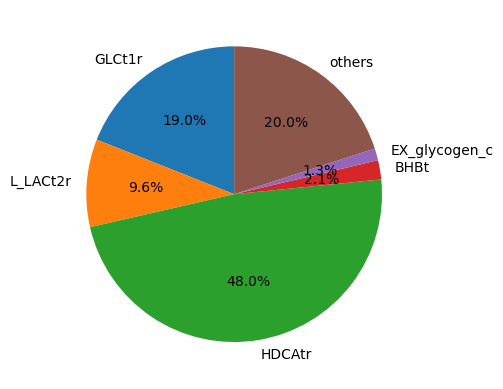

In [25]:
# Make a pi chart of the carbon contribution of the different metabolites
# Uptakes rates 
import pandas as pd

rows = ['GLCt1r',  'L_LACt2r','HDCAtr', 'BHBt','EX_glycogen_c']
carbons = pd.Series({ 'GLCt1r': 6, 'L_LACt2r': 3, 'HDCAtr': 16, 'BHBt': 4, 'EX_glycogen_c':6 })[rows]

uptake_flux = sol.fluxes[rows].abs() * carbons[rows]

# 25% others 
uptake_flux['others'] = uptake_flux.abs().sum() * (1/0.80 - 1)

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.pie(uptake_flux, labels=uptake_flux.index, autopct='%1.1f%%', startangle=90)

plt.show()


In [26]:
# Function to integrate metabolite concentrations
import numpy as np 
from optlang.exceptions import SolverError

def set_concentration(model, metabolite_id, concentration, uncertainty=0.1, unit='mmol/L', std=None):
    if unit == 'mmol/L':
        concentration = concentration / 1000
        if not std is None:
            std = std/1000
        if not np.isscalar(uncertainty):
            uncertainty = [x/1000 for x in uncertainty]
    else:
        raise ValueError('Unit not supported')
    

    metabolite = model.log_concentration.get_by_id(metabolite_id)
    compartment = model.metabolites.get_by_id(metabolite_id).compartment
    c_min = reduced_model.compartments[compartment]['c_min']

    var = metabolite.variable

    if (std is None) and np.isscalar(uncertainty):
        try:            
            var.ub = np.log(concentration + concentration * uncertainty)
            var.lb = np.log(concentration - concentration * uncertainty)
        except ValueError:
            var.lb = np.log(concentration - concentration * uncertainty)
            var.ub = np.log(concentration + concentration * uncertainty)
    elif (std is None) and (len(uncertainty) == 2):
        try:
            var.lb = np.log(uncertainty[0])
            var.ub = np.log(uncertainty[1])
        except ValueError:
            var.ub = np.log(uncertainty[1])
            var.lb = np.log(uncertainty[0])
    elif std is not None:
        try:
            var.ub = np.log(concentration + std)
            lb = np.log(concentration - std) if concentration - std > c_min else np.log(c_min)
            var.lb = lb
        except ValueError:
            lb = np.log(concentration - std) if concentration - std > c_min else np.log(c_min)
            var.lb = lb
            var.ub = np.log(concentration + std)
    else:
        raise ValueError('Uncertainty not supported')
        
    # Test the constraint
    try:
        sol = model.optimize()
        if sol.status != 'optimal':
            raise ValueError(f'Constraining {metabolite_id} to {concentration} failed.')
    except:
        raise ValueError(f'Constraning {metabolite_id} to {concentration} failed.')
    

In [27]:
from pytfa.optim.variables import LogConcentration
TVA = variability_analysis(reduced_model, kind=LogConcentration)

2025-03-04 11:40:24,180 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 83/83 [00:01<00:00, 63.06it/s]


In [28]:
# Integrate serum metabolomics 

# Glucose concentration in serum
glucose_concentration = 5.5 # mmol/L 
# Lactate concentration in serum
lactate_concentration = 0.75 # mmol/L
# Fatty-acid concentration in serum
fatty_acid_concentration = 0.5 # mmol/L
# Ketone concentration in serum 
ketone_concentration = 0.1 # mmol/L

# O2 concentration in serum 80 mmHG -> to mmol/L
T = 273.15 + 37
o2_concentration_artery = 1e3 * 80/ (62.36367*T)
o2_concentration_muscle = 1e3 * 30/ (62.36367*T)

# CO2 concentration in serum 40 mmHG -> to mmol/L
co2_concentration = 1e3 * 40/ (62.36367*T)


set_concentration(reduced_model, 'glc_D_e', glucose_concentration, uncertainty=0.1)

set_concentration(reduced_model, 'lac_L_e', lactate_concentration, uncertainty=0.1)
set_concentration(reduced_model, 'lac_L_c', lactate_concentration*0.8, uncertainty=0.9)

set_concentration(reduced_model, 'hdca_e', fatty_acid_concentration, uncertainty=0.1)

set_concentration(reduced_model, 'bhb_e', ketone_concentration, uncertainty=0.1)    

set_concentration(reduced_model, 'o2_e', o2_concentration_muscle, uncertainty=0.1)
set_concentration(reduced_model, 'o2_c', o2_concentration_muscle*0.9, uncertainty=0.1)
set_concentration(reduced_model, 'o2_m', o2_concentration_muscle*0.8, uncertainty=0.1)

set_concentration(reduced_model, 'co2_e', co2_concentration, uncertainty=0.1)   


# Phosphate concentration 5 mM 
# https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2012.00463/full
set_concentration(reduced_model, 'pi_c', 5, 0.9)
#set_concentration(reduced_model, 'pi_m', 12, 0.5)


# Set the concentration of the cytosol -> 10% of the serum concentration
set_concentration(reduced_model, 'hdca_c', fatty_acid_concentration*0.1)

reduced_model.optimize()


,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442627,None
AKGDm,0.442627,None
AKGMALtm,0.000000,None
ASPGLUm,0.000000,None
...,...,...
cyt_atp2adp,6.030280,None
PiC,6.018884,None
glycogen_synthesis,0.001000,None
glycogen_degradation,0.003749,None


In [29]:
# Run a flux analysis to see how constrain is the flux distribution
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')


2025-03-04 11:40:26,444 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 76/76 [00:00<00:00, 319.74it/s]


In [30]:
#reduced_model.solver.problem.conflict.refine()
#reduced_model.solver.problem.conflict.write('bla.txt')

In [31]:
# Read the tissue metabolomics data
import pandas as pd
tissue_metabolomics = pd.read_csv('./../data/C57BL6_6hr_fasted.csv')

tissue_type = 'Soleus'

tissue_samples = tissue_metabolomics.Tissue == tissue_type
tissue_metabolomics[tissue_samples]



,Tissue,a-ketoglutarate,alanine,arginine,asparagine,aspartate,citrate,fumarate,glutamate,glutamine,...,methionine,phenylalanine,proline,pyruvate,serine,succinate,threonine,tryptophan,tyrosine,valine
48,Soleus,164.82,8830.95,166.09,125.35,343.31,506.18,41.44,4334.70,3264.68,...,32.66,58.63,86.84,375.54,261.30,74.22,197.54,15.66,43.59,171.44
49,Soleus,270.08,20673.02,135.75,175.04,1091.43,441.79,63.14,4171.56,2943.38,...,42.34,78.29,86.92,560.16,315.55,173.60,236.77,14.86,71.53,184.09
50,Soleus,221.14,18248.35,190.22,196.63,2462.46,390.77,93.81,2686.22,2526.05,...,65.75,70.51,124.80,717.46,374.81,183.29,302.36,17.03,115.98,187.89
51,Soleus,218.93,18785.52,180.17,183.07,1992.65,354.46,95.38,3141.48,2557.69,...,61.26,60.67,123.48,698.18,370.55,181.01,277.40,17.02,95.59,191.78


In [32]:
# Metabolomics from taras paper (we use soleus concentrtions)
set_concentration(reduced_model, 'g6p_c', 0.45, uncertainty=0.9)
set_concentration(reduced_model, 'f6p_c', 0.45, uncertainty=0.9) # (Assuumes 50/50 splot in g6p anf f6p)
set_concentration(reduced_model, 'fdp_c', 0.44, std=0.18)
set_concentration(reduced_model, 'g3p_c', 0.43, uncertainty=0.9)

reduced_model.optimize()


,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442627,None
AKGDm,0.442627,None
AKGMALtm,0.000000,None
ASPGLUm,0.000000,None
...,...,...
cyt_atp2adp,6.030280,None
PiC,6.018884,None
glycogen_synthesis,0.001000,None
glycogen_degradation,0.003749,None


In [33]:
TVA = variability_analysis(reduced_model, kind=DeltaG)

# Transform from log to log10 -> scale with log10(e)
TVA['minimum'] = TVA.minimum * np.log10(np.exp(1))
TVA['maximum'] = TVA.maximum * np.log10(np.exp(1))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

# Print a list of delta G with low range
for met_id in TVA.index:
    entry = TVA.loc[met_id]
    if abs(entry['minimum']) < 1e-3 and abs(entry['maximum']) < 1e-3:
        print(met_id, entry['minimum'], entry['mid'], entry['maximum'])
        print('-------------------')


2025-03-04 11:40:27,206 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 63/63 [00:01<00:00, 38.38it/s]


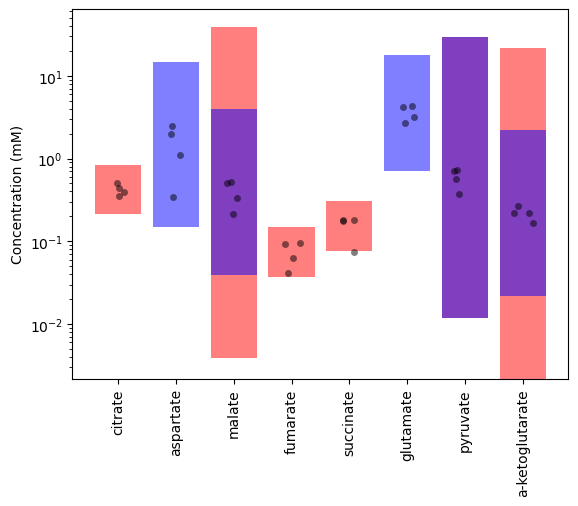

In [34]:

metabolite_mapping = [
    ('a-ketoglutarate', ('akg_m', 100.0)),
    ('a-ketoglutarate', ('akg_c', 10.0)),
    ('citrate', ('cit_m', 2.0)),
    ('fumarate', ('fum_m', 2.0)),
    #('lactate', ('lac_L_c', 5.0)),
    #('lactate', ('lac_L_m', 5.0)),
    ('malate', ('mal_L_m', 100.0)),
    ('malate', ('mal_L_c', 10.0)),
    ('pyruvate', ('pyr_m', 50.0)),
    ('pyruvate', ('pyr_c', 50.0)),
    ('succinate', ('succ_m',  2.0)),
    #('glutamate', ('glu_L_m', 100.0)),
    ('glutamate', ('glu_L_c', 5.0)),
    #('aspartate', ('asp_L_m', 10.0)),
    ('aspartate', ('asp_L_c', 10.0)),
]

metabolites_to_map = list(set(m[0] for m in metabolite_mapping))
data_extracted = tissue_metabolomics[tissue_samples][metabolites_to_map] * 1e-3 # convert uM to mM 

# Plot the metabolomics data and the assumed bounds for the metabolites
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
# Plot all the data points 
sns.stripplot(data=data_extracted, ax=ax, jitter=0.2, color='black', alpha=0.5)

means = data_extracted.mean()

# Compute mitochondrial and cytosolic ranges -> mean/scaling , mean*scaling
ranges = []
for met, (met_id, scaling) in metabolite_mapping:
    mid = means[met]
    lb = mid / scaling
    ub = mid * scaling
    if met_id.endswith('_m'):
        ranges.append({'metabolite': met, 'lb': lb, 'ub': ub, 'compartment': 'mitochondrial'})
    else:
        ranges.append({'metabolite': met, 'lb': lb, 'ub': ub, 'compartment': 'cytosolic'})

ranges = pd.DataFrame(ranges)

# Plot the mitochondiral and cytosolic ranges as ractangles between lb and ub 
ranges = ranges.set_index('metabolite')
mit_ranges = ranges[ranges.compartment == 'mitochondrial']
cyt_ranges = ranges[ranges.compartment == 'cytosolic']

plt.bar(mit_ranges.index, mit_ranges.ub - mit_ranges.lb, bottom=mit_ranges.lb, color='red', alpha=0.5)
plt.bar(cyt_ranges.index, cyt_ranges.ub - cyt_ranges.lb, bottom=cyt_ranges.lb, color='blue', alpha=0.5)

plt.yscale('log')

plt.xticks(rotation=90)

plt.ylabel('Concentration (mM)')

plt.show()

In [35]:
# # # Map the metabolomics data to the model
for metabolite_name, (metabolite_id, uncertainty_fac) in metabolite_mapping:
    concentration = data_extracted[metabolite_name].mean()
    uncertainty = data_extracted[metabolite_name].std()
    #print(f"{metabolite_name} concentration: {concentration} +/- {uncertainty*uncertainty_fac}")
    uncertainty = (concentration / uncertainty_fac, concentration * uncertainty_fac)
    set_concentration(reduced_model, metabolite_id, concentration, uncertainty=uncertainty)
    


In [36]:
# Carnitine concentration in Muscle 500 pmol/mg -> (1000g/L density of muscle) -> 500 uM
carnitine_concentration = 500e-3
set_concentration(reduced_model, 'crn_c', carnitine_concentration, 0.99)
set_concentration(reduced_model, 'crn_m', carnitine_concentration, 0.99)

# Long chain acyl-carnitine concentration 01 - 10 uM in Muscle 
# https://www.nature.com/articles/s41598-017-17797-x
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4274800/
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4274800/
set_concentration(reduced_model, 'pmtcrn_c', 5e-3 , 0.9)
set_concentration(reduced_model, 'pmtcrn_m', 5e-3 , 0.99)

# acyl-CoA in Muscle
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4274800/
set_concentration(reduced_model, 'pmtcoa_c', 1e-3 , 0.9)
set_concentration(reduced_model, 'pmtcoa_m', 1e-3 , 0.99)

# CoA in Muscle
set_concentration(reduced_model, 'coa_c', 1.0e-3 , 0.99)
set_concentration(reduced_model, 'coa_m', 1.0e-3 , 0.99)


# Try glycerol-3 phosphate integration (assumed to quite abundand in muscle)
# https://www.nature.com/articles/s41387-018-0045-x -> 10 - 100 uM
set_concentration(reduced_model, 'glyc3p_c', 100e-3, 0.99)


sol = reduced_model.optimize()
print(sol.objective_value)

5.998793666666669


In [37]:
FVA.loc['L_LACDcm']

minimum    0.0
maximum    0.0
Name: L_LACDcm, dtype: float64

In [38]:
FVA

,minimum,maximum
ACACT1rm,-0.006636,-0.006636
ACONTm,0.442627,0.442627
AKGDm,0.442627,0.442627
AKGMALtm,0.000000,18.331575
ASPGLUm,0.000000,18.331575
...,...,...
cyt_atp2adp,1.000000,6.030280
PiC,1.435991,6.018884
glycogen_synthesis,0.001000,5.031280
glycogen_degradation,0.003749,5.034030


In [39]:
TVA = variability_analysis(reduced_model, kind=DeltaG)

# Transform from log to log10 -> scale with log10(e)
TVA['minimum'] = TVA.minimum * np.log10(np.exp(1))
TVA['maximum'] = TVA.maximum * np.log10(np.exp(1))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

# Print a list of delta G with low range
for met_id in TVA.index:
    entry = TVA.loc[met_id]
    if abs(entry['minimum']) < 1e-3 and abs(entry['maximum']) < 1e-3:
        print(met_id, entry['minimum'], entry['mid'], entry['maximum'])
        print('-------------------')




2025-03-04 11:40:31,384 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 63/63 [00:01<00:00, 38.88it/s]


In [40]:
# Print malate aspartate shuttle free ene
aspartate_malate_shuttle= ['MDH', 'ASPTA', 'ASPTAm', 'MDHm', 'ASPGLUm', 'AKGMALtm']
lactate_shuttle = ['LDH_L', 'LDH_Lm', 'PYRt2m','L_LACDcm' ]

for rxn_id in lactate_shuttle:
    entry = TVA.loc["DG_"+rxn_id]
    rxn = reduced_model.reactions.get_by_id(rxn_id)
    print(rxn_id,rxn.reaction, entry['minimum'], entry['maximum'])
    print('-------------------')

LDH_L lac_L_c + nad_c <=> h_c + nadh_c + pyr_c -0.18904288546783282 4.5928381529272934e-15
-------------------
LDH_Lm lac_L_m + nad_m <=> h_m + nadh_m + pyr_m 0.5308647858057689 7.322189541226171
-------------------
PYRt2m h_c + pyr_c <=> h_m + pyr_m -0.6627148199365896 7.562510087824137e-08
-------------------
L_LACDcm 2.0 ficytC_m + lac_L_c --> 2.0 focytC_m + 2.0 h_c + pyr_c -12.519473831929131 -8.560281450211265
-------------------


In [41]:
rxns = ['AKGMALtm', 'G3PD1', 'glycogen_degradation', 'EX_glycogen_c']
FVA.loc[ rxns , :]

,minimum,maximum
AKGMALtm,0.000000,18.331575
G3PD1,-1.851891,0.000000
glycogen_degradation,0.003749,5.034030
EX_glycogen_c,-0.002749,-0.002749


In [42]:
# Here we choose a flux profile
reduced_model.optimize()

# Limit LDHm reverse
reduced_model.reactions.LDH_Lm.bounds = (-0.01, -0.001)

# Assume the direaction of all three shuttles
reduced_model.reactions.AKGMALtm.bounds = (0.0, 2.0)
reduced_model.reactions.G3PD1.bounds = (-2.0, -0.0)


# Glycogen deg
reduced_model.reactions.glycogen_degradation.bounds = (0.001, 0.1)

# Glycogen exchange
reduced_model.reactions.EX_glycogen_c.bounds = (-0.01, -0.001)

# This is not the function associated with this transporter
# https://slc.bioparadigms.org/protein?GeneName=SLC25A10    
reduced_model.reactions.r0822.bounds = (0.0, 0.0)

sol = reduced_model.optimize()


In [43]:
# Run a flux analysis to see how constrain is the flux distribution
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')


2025-03-04 11:40:34,846 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 76/76 [00:00<00:00, 316.90it/s]


In [44]:
# Remove the reactions that cannot carry flux
EPSILON = 1e-6  
reactions_to_remove = [r for r in reduced_model.reactions if FVA.loc[r.id, 'minimum'] >= -EPSILON and FVA.loc[r.id, 'maximum'] <= EPSILON ]
print(reactions_to_remove)
reduced_model.remove_reactions(reactions_to_remove)
reduced_model.repair()

metabolites_to_remove = [m for m in reduced_model.metabolites if len(m.reactions) == 0]
reduced_model.remove_metabolites(metabolites_to_remove)
reduced_model.repair()

sol = reduced_model.optimize()
print(sol.objective_value)

[<Reaction L_LACDcm at 0x7f7db86203d0>, <Reaction r0822 at 0x7f7db86205e0>, <Reaction FUM at 0x7f7db86208b0>, <Reaction ACYP at 0x7f7db8620af0>]
5.998543666666669


In [45]:
# Run a flux analysis to see how constrain is the flux 
from pytfa.analysis import variability_analysis
FVA = variability_analysis(reduced_model, kind='reactions')

# Plot the fluxes as bars starting at min and ending at max
FVA['range'] = FVA.maximum - FVA.minimum
FVA['mid'] = (FVA.maximum + FVA.minimum) / 2

fasted_fluxes = FVA['mid']

2025-03-04 11:40:35,410 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 72/72 [00:00<00:00, 367.36it/s]


In [46]:
atp2adp_bounds = FVA.loc['cyt_atp2adp',['minimum', 'maximum']].values

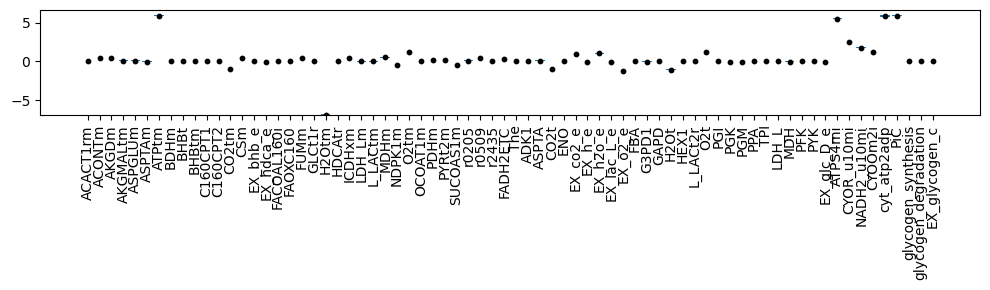

In [47]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

f = plt.figure(figsize=(10, 3))
plt.bar(FVA.index, FVA.range, bottom=FVA.minimum)
plt.scatter(FVA.index, FVA.mid, color='k', s=10)

# from cobra.flux_analysis.parsimonious import optimize_minimal_flux
# reduced_model.objective = reduced_model.problem.Objective(reduced_model.reactions.cyt_atp2adp.forward_variable, direction='max')
# sol = optimize_minimal_flux(reduced_model)
# plt.scatter(sol.fluxes.index, sol.fluxes, color='r', s=10)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [48]:
# Print bidreactional reactions from FVA
for r in reduced_model.reactions:
    if FVA.loc[r.id, 'minimum'] < -EPSILON and FVA.loc[r.id, 'maximum'] > EPSILON:
        print(r.id, r.reaction, FVA.loc[r.id, ['minimum', 'maximum']].values)


In [49]:
# Force minimal flux of 1e-4 and deltaG of -1e-4
EPSILON_DG = 0.01 # kcal/mol
EPSILON_FLUX = 0.005
sol = reduced_model.optimize()

for rxn in reduced_model.reactions:
    sol = reduced_model.optimize()
    primal_dg = None
    if FVA.loc[rxn.id].maximum > 0:

        rxn.bounds = (EPSILON_FLUX, rxn.bounds[1])
        try:
            deltaG = reduced_model.delta_g.get_by_id(rxn.id).variable
            deltaG.ub = -EPSILON_DG
        except KeyError:
            pass
            
    elif FVA.loc[rxn.id].minimum < 0:
        rxn.bounds = (rxn.bounds[0], -EPSILON_FLUX)
        try:
            deltaG = reduced_model.delta_g.get_by_id(rxn.id).variable
            deltaG.lb = EPSILON_DG
        except KeyError:
            pass
    else:
        raise ValueError(f"Somthing is really from with {rxn.id}")

    try:
        sol = reduced_model.optimize()
        if sol.status != 'optimal':
            raise SolverError(f"Failed to constrain {rxn.id} as {primal_dg}")
    except SolverError:
        raise SolverError(f"Failed to constrain {rxn.id} as {primal_dg}")
    


2025-03-04 11:40:36,916 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 81/81 [00:00<00:00, 447.55it/s]


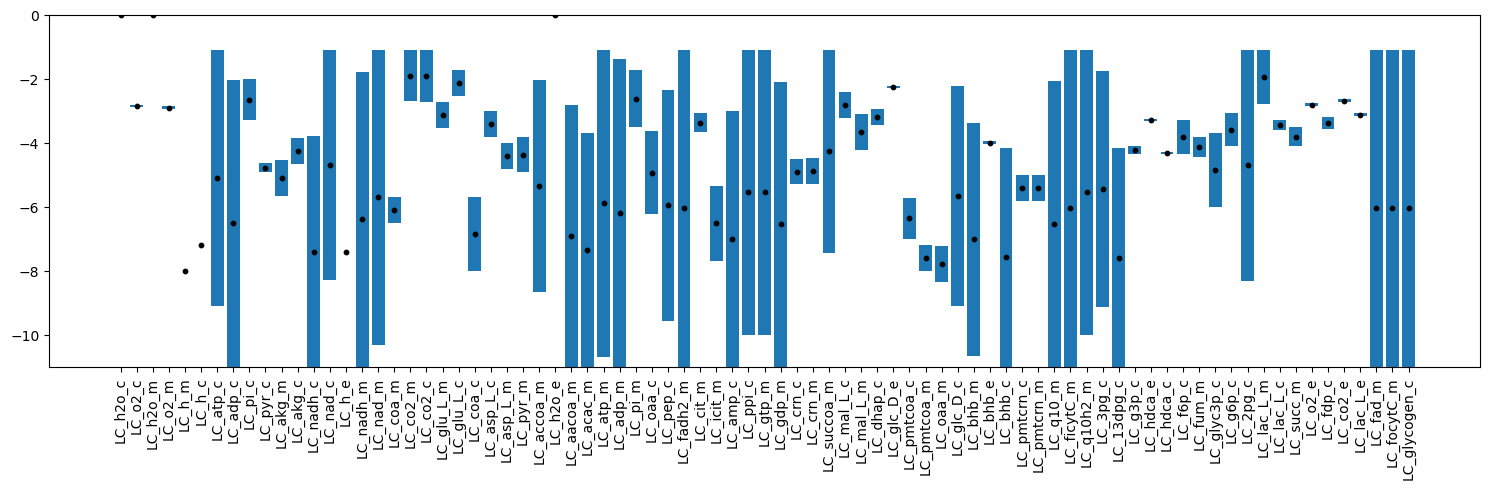

In [50]:
# Plot the flux variablity analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Concentration of metabolites
from pytfa.optim.variables import LogConcentration
TVA = variability_analysis(reduced_model, kind=LogConcentration)


# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))

# Transform from log to log10 -> scale with log10(e)
TVA['minimum'] = TVA.minimum * np.log10(np.exp(1))
TVA['maximum'] = TVA.maximum * np.log10(np.exp(1))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2


plt.bar(TVA.index, TVA.range, bottom=TVA.minimum)
plt.scatter(TVA.index, TVA.mid, color='k', s=10)
plt.xticks(np.arange(len(TVA.index)), TVA.index, rotation=90)
plt.tight_layout()

plt.show()

In [51]:
from pytfa.analysis import  apply_reaction_variability,     \
                            apply_generic_variability,      \
                            apply_directionality

from pytfa.optim.variables import DeltaG,DeltaGstd,LogConcentration
# Fesiblitity analysis
solution = reduced_model.optimize()


# TVA of the model
thermo_vars = [DeltaG,DeltaGstd,LogConcentration]
TVA = variability_analysis(reduced_model, kind=thermo_vars)
FVA = variability_analysis(reduced_model, kind='reactions')


# Strip model of integers variables
fixed_directionality_model = apply_directionality(reduced_model, solution)
tight_model = apply_reaction_variability(fixed_directionality_model, FVA)
tight_model = apply_generic_variability (tight_model  , TVA)
 

 # Make surethe atp bounds are integrated
tight_model.reactions.cyt_atp2adp.bounds = atp2adp_bounds

2025-03-04 11:40:37,576 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 59/59 [00:00<00:00, 470.12it/s]
2025-03-04 11:40:37,898 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaGstd'>
maximizing: 100%|██████████| 59/59 [00:00<00:00, 494.99it/s]
2025-03-04 11:40:38,127 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 81/81 [00:00<00:00, 466.89it/s]
2025-03-04 11:40:38,515 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 72/72 [00:00<00:00, 253.31it/s]


In [52]:
FVA.loc['cyt_atp2adp']

minimum    0.893750
maximum    6.011546
Name: cyt_atp2adp, dtype: float64

In [53]:
from pytfa.optim import strip_from_integer_variables
from pytfa.analysis import sample

continuous_model = strip_from_integer_variables(tight_model)
continuous_model.repair()

2025-03-04 11:40:39,268 - thermomodel_Recon3thermoCurated - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


Is the cobra_model still integer ? False


In [54]:
 # Make surethe atp bounds are integrated
continuous_model.reactions.cyt_atp2adp.lower_bound  = atp2adp_bounds[0]
continuous_model.reactions.cyt_atp2adp.upper_bound  = atp2adp_bounds[1]

continuous_model.optimize()

continuous_model.reactions.cyt_atp2adp 

Reaction identifier,cyt_atp2adp
Name,
Memory address,0x07f7da9fb7e20
Stoichiometry,atp_c + h2o_c --> adp_c + h_c + pi_c Adenosine Triphosphate + Water --> Adenosine Diphosphate + Proton + Orthophosphate
GPR,
Lower bound,5.798083000000002
Upper bound,5.998543666666669


In [55]:
continuous_model.solver.configuration.tolerances.feasibility = 1e-9
continuous_model.solver.configuration.tolerances.optimality = 1e-9
continuous_model.solver.configuration.tolerances.integrality = 1e-9


In [56]:
# Gelta D constraints for glycolysis (Lehninger)
continuous_model.delta_g.HEX1.variable.ub = -20 * 0.239006
continuous_model.delta_g.HEX1.variable.lb = -33.4 * 0.239006

# Make sure PYK is fwd driven
continuous_model.delta_g.PYK.variable.ub = -10 * 0.239006
continuous_model.delta_g.PYK.variable.lb = -30 * 0.239006

# PFK 
continuous_model.delta_g.PFK.variable.ub = -10 * 0.239006
continuous_model.delta_g.PFK.variable.lb = -25 * 0.239006

continuous_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442627,None
AKGDm,0.442627,None
AKGMALtm,0.125947,None
ASPGLUm,0.125947,None
...,...,...
cyt_atp2adp,5.998544,None
PiC,5.982398,None
glycogen_synthesis,0.005000,None
glycogen_degradation,0.015000,None


In [57]:
# Rest of glycolysis close to equilibrium
continuous_model.delta_g.PGI.variable.lb = -0.1 * 0.239006 # Shu be very close to equilibrium
continuous_model.delta_g.FBA.variable.lb = -0.1 * 0.239006 # 6 in lehninger but we make it more reversible since glycolysis bearly active
continuous_model.delta_g.TPI.variable.lb = -0.1 * 0.239006 # Shu be very close to equilibrium
continuous_model.delta_g.PGM.variable.ub = 0.1 * 0.239006 # reverse annotated
continuous_model.delta_g.PGK.variable.ub = 0.1 * 0.239006 # reverse annotated
continuous_model.delta_g.GAPD.variable.lb = -0.1 * 0.239006
continuous_model.delta_g.ENO.variable.lb = -0.1 * 0.239006

continuous_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442627,None
AKGDm,0.442627,None
AKGMALtm,0.125947,None
ASPGLUm,0.125947,None
...,...,...
cyt_atp2adp,5.998544,None
PiC,5.982398,None
glycogen_synthesis,0.005000,None
glycogen_degradation,0.015000,None


In [58]:
# Mitochondrial lactate transport close to equilibrium
continuous_model.delta_g.L_LACtm.variable.lb = 0.001 # kcal/mol
continuous_model.delta_g.L_LACtm.variable.ub = 0.01 # kcal/mol

# Latate transport L_LACt2r
continuous_model.delta_g.L_LACt2r.variable.lb = -0.5 # kcal/mol

continuous_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442627,None
AKGDm,0.442627,None
AKGMALtm,0.125947,None
ASPGLUm,0.125947,None
...,...,...
cyt_atp2adp,5.998544,None
PiC,5.982398,None
glycogen_synthesis,0.005000,None
glycogen_degradation,0.015000,None


In [59]:
# Other considerations
# PDHm is thought to be displaced from equilibrium
continuous_model.delta_g.PDHm.variable.ub = -1.0 # kcal/mol

# SCCOAS is not regulated -> close to equilibrium
continuous_model.delta_g.SUCOAS1m.variable.ub = 0.1 # kcal/mol

# AConitase close to equilibrium
continuous_model.delta_g.ACONTm.variable.lb = -0.1 # kcal/mol
# ICDHm close to equilibrium
continuous_model.delta_g.ICDHxm.variable.lb = -0.5 # kcal/mol

# Limit CPT1 and CPT2 to a small range 1-2 kcal/mol
continuous_model.delta_g.C160CPT2.variable.lb = -0.1 # kcal/mol
continuous_model.delta_g.C160CPT1.variable.lb = -0.1 # kcal/mol

# NDPK1m close to equilibrium (GTP/ATP interconversion)
# continuous_model.delta_g.ADK1.variable.lb = -0.5 # kcal/mol
continuous_model.delta_g.NDPK1m.variable.ub = 0.1 # kcal/mol

# Limit irreverisblity of GPD1 and MDH
continuous_model.delta_g.MDH.variable.ub = 0.1

# Limit the irreversibility of the glycerol-3-phosphate shuttle
# continuous_model.delta_g.G3PD1.variable.ub = 2.5


# THOUGHT ADK needs to be some version of forward driven so that it can flip! to make AMP 
#continuous_model.delta_g.ADK1.variable.ub = -2.0
continuous_model.delta_g.FACOAL160i.variable.ub = -2.0

#
continuous_model.delta_g.MDHm.variable.ub = -0.001
continuous_model.delta_g.MDHm.variable.lb = -0.1


# Tiny bit of forward driven 3HB metabolism
continuous_model.delta_g.ACACT1rm.variable.lb = 0.01
continuous_model.delta_g.ACACT1rm.variable.ub = 0.5


continuous_model.optimize()

,fluxes,reduced_costs
ACACT1rm,-0.006636,None
ACONTm,0.442627,None
AKGDm,0.442627,None
AKGMALtm,0.125947,None
ASPGLUm,0.125947,None
...,...,...
cyt_atp2adp,5.998544,None
PiC,5.982398,None
glycogen_synthesis,0.005000,None
glycogen_degradation,0.015000,None


In [60]:
# ELECTRON TRANSPORT CHAIN - THE ETC is thermodynamically controled -> close to equilibrium
continuous_model.delta_g.NADH2_u10mi.variable.lb = -0.5 # kcal/mol
continuous_model.delta_g.CYOR_u10mi.variable.lb = -0.5 # kcal/mol
continuous_model.delta_g.CYOOm2i.variable.lb = -0.5 # kcal/mol


# # Min displacement 
continuous_model.delta_g.NADH2_u10mi.variable.ub = -0.05 # kcal/mol
continuous_model.delta_g.CYOR_u10mi.variable.ub = -0.05 # kcal/mol
continuous_model.delta_g.CYOOm2i.variable.ub = -0.05 # kcal/mol


# Complex II like entry into ETC - Not sure about the thermodynamics
# Succinate dehydrogenase should be displced from equilibrium! 
#continuous_model.delta_g.r0509.variable.lb = -1.0 # kcal/mol
continuous_model.delta_g.FADH2ETC.variable.ub = -0.5 # kcal/mol


sol = continuous_model.optimize()

In [61]:
continuous_model.delta_g.ATPS4mi.variable.lb = -0.5
continuous_model.delta_g.ATPS4mi.variable.ub = -0.05
sol = continuous_model.optimize()

In [62]:
continuous_model.delta_g.ATPtm.variable.lb = -2.0
sol = continuous_model.optimize()

In [63]:
# Oxygen transport is fast - close to equilibrium
continuous_model.delta_g.O2t.variable.lb = -0.1 # kcal/mol
continuous_model.delta_g.O2tm.variable.lb = -0.1 # kcal/mol

In [65]:
# Make some assumption on the most importat 

# NAD concentration
nad_concentration = 1.5 # mM
set_concentration(continuous_model, 'nad_c', nad_concentration, uncertainty=0.9)
set_concentration(continuous_model, 'nad_m', nad_concentration, uncertainty=0.9)

# Assumption of OAA 10 uM rangge
set_concentration(continuous_model, 'oaa_m', 1e-3, 0.99)
set_concentration(continuous_model, 'oaa_c', 10e-3, 0.9)

# FAD concentration
fad_concentration = 10e-3# mM 
set_concentration(continuous_model, 'fad_m', fad_concentration, uncertainty=0.9)
set_concentration(continuous_model, 'fadh2_m', fad_concentration*0.1, uncertainty=0.9)


# GDP concentration
gdp_concentration = 0.05 # mM
set_concentration(continuous_model, 'gtp_m', gdp_concentration, uncertainty=0.5)

# ATP concentration 5 mM range
set_concentration(continuous_model, 'atp_c', 5.0, uncertainty=0.5)


# Mitochondiral ATP concentration 
set_concentration(continuous_model, 'atp_m', 5.0, uncertainty=0.5)

# Ubiqionone 40 uM range  https://www.nature.com/articles/pr2015124
set_concentration(continuous_model, 'q10h2_m' , 40e-3, uncertainty=0.5)
set_concentration(continuous_model, 'q10_m' , 4e-3, uncertainty=0.9)

# Ferrocyto-chrome 1uM range
set_concentration(continuous_model, 'ficytC_m', 1e-3, uncertainty=0.5)

# # Acetocatete concentrion << Km of OCOAT1m
# set_concentration(continuous_model, 'acac_m', 10e-3, uncertainty=0.99)

# Accetoacetate CoA concentration in 1uM range
set_concentration(continuous_model, 'aacoa_m', 1e-3, uncertainty=0.9)

# Diphotphate 0.1 mM ?!
set_concentration(continuous_model, 'ppi_c', 0.1, 0.9)

# Intra cellular glucose should be lowish 1-10 uM
set_concentration(continuous_model, 'glc_D_c',  50e-3, 0.99)

# Actetyl coa in 500 uM range
set_concentration(continuous_model, 'accoa_m', 500e-3, 0.99)

# succoa_m 10 uM range
set_concentration(continuous_model, 'succoa_m', 50e-3, 0.99)

# mitochondiral co2 abour 2 fold hiher than extracellular + gradient
set_concentration(continuous_model, 'co2_m', 1.5 * co2_concentration, 0.1)
set_concentration(continuous_model, 'co2_c', 1.25 * co2_concentration, 0.1)

# Glycogen concentration 100 mM
set_concentration(continuous_model, 'glycogen_c', 100, 0.9)


In [66]:
TVA = variability_analysis(continuous_model, kind=LogConcentration)


2025-03-04 11:40:39,698 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 81/81 [00:00<00:00, 4315.84it/s]


In [67]:
# Sample the concnetrations and fluxes in the continuous_model
sampling = sample(continuous_model, 1000, processes=4, seed=0,  method='optgp')

2025-03-04 11:40:39,928 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2025-03-04 11:40:40,463 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2025-03-04 11:40:40,909 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACACT1rm
2025-03-04 11:40:40,912 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ACONTm_reverse_8079b
2025-03-04 11:40:40,913 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGDm_reverse_ec8eb
2025-03-04 11:40:40,915 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable AKGMALtm_reverse_8c3a3
2025-03-04 11:40:40,916 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed variable ASPGLUm_reverse_b29bf
2025-03-04 11:40:40,916 - thermomodel_Recon3thermoCurated - continuous - INFO - skipping fixed 

2025-03-04 11:40:47,276 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.LogConcentration'>
maximizing: 100%|██████████| 81/81 [00:00<00:00, 3996.64it/s]


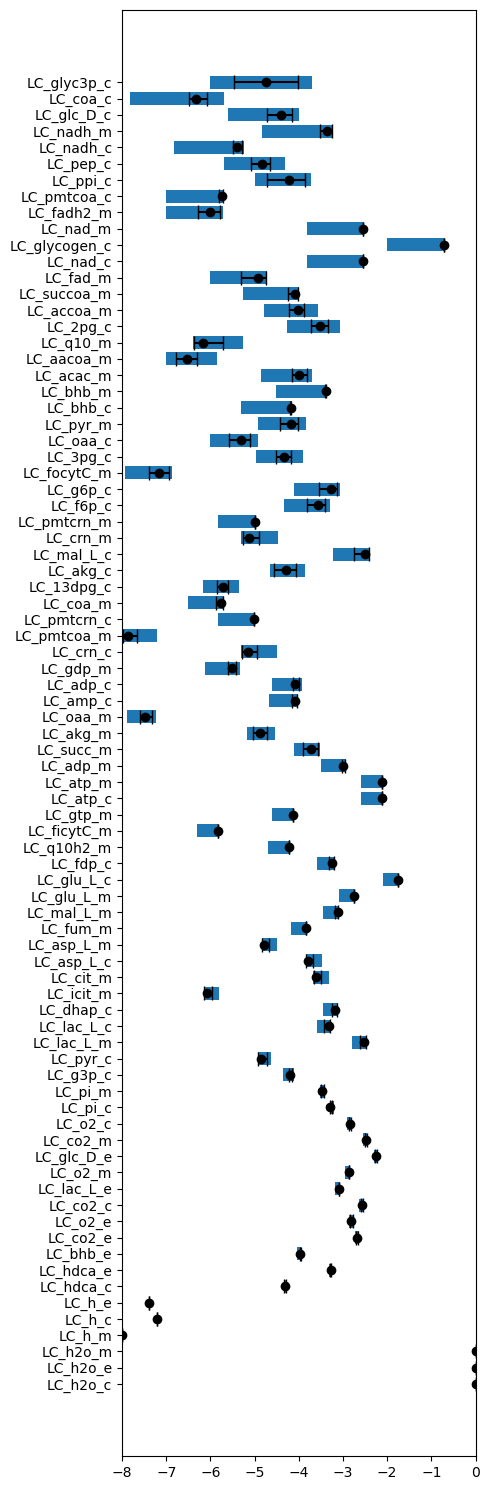

In [68]:
TVA = variability_analysis(continuous_model, kind=LogConcentration)

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(5, 15))

# Convert from ln to log10
TVA['minimum'] = np.log10(np.exp(TVA.minimum))
TVA['maximum'] = np.log10(np.exp(TVA.maximum))
sampling_log10 = np.log10(np.exp(sampling))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

# TVA sort by range
TVA = TVA.sort_values('range', ascending=True)

LC_MEDIAN = sampling_log10.median()[TVA.index]
LC_UQ = sampling_log10.quantile(0.95)[TVA.index]
LC_LQ = sampling_log10.quantile(0.05)[TVA.index]


plt.barh(TVA.index, TVA.range, left=TVA.minimum)
plt.errorbar( LC_MEDIAN, TVA.index, xerr=[LC_MEDIAN - LC_LQ, LC_UQ - LC_MEDIAN], fmt='o', color='k', ecolor='k', capsize=5)
# Align the xticks with the metabolites names
plt.yticks(np.arange(0,len(TVA.index)),  TVA.index,)
plt.tight_layout()
plt.show()



In [69]:
TVA.loc[['LC_bhb_e', 'LC_bhb_c', 'LC_bhb_m']]

,minimum,maximum,range,mid
LC_bhb_e,-4.045757,-3.958607,0.087150,-4.002182
LC_bhb_c,-5.305188,-4.165794,1.139394,-4.735491
LC_bhb_m,-4.512860,-3.373465,1.139394,-3.943162


2025-03-04 11:40:47,721 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type <class 'pytfa.optim.variables.DeltaG'>
maximizing: 100%|██████████| 59/59 [00:00<00:00, 3480.02it/s]


(-20.0, 10.0)

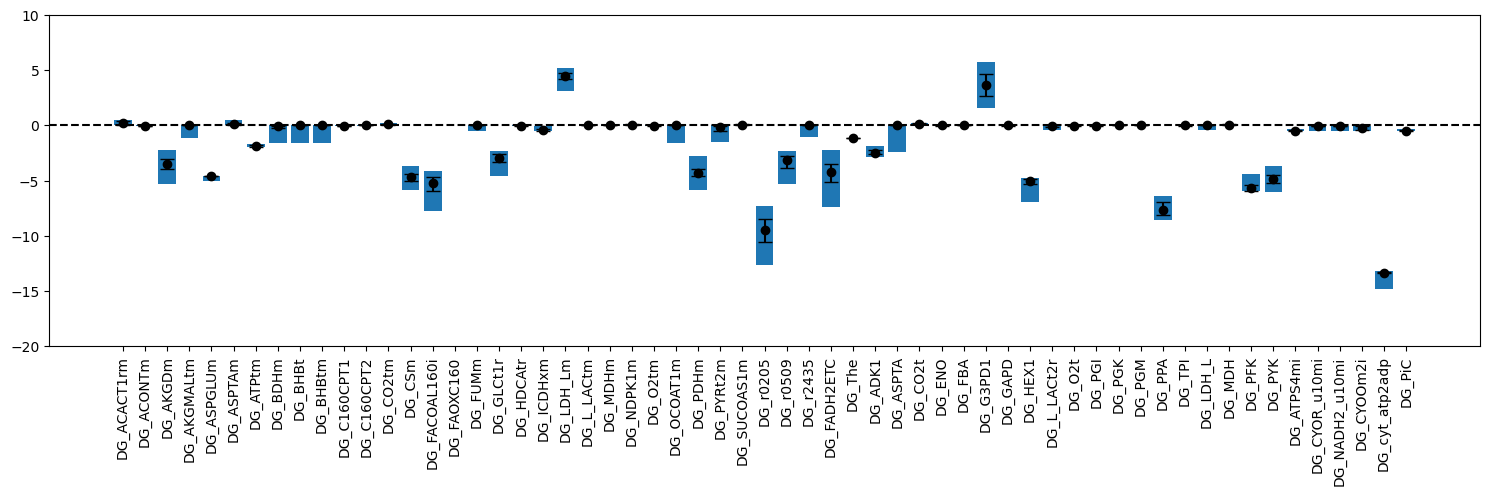

In [70]:
from pytfa.optim.variables import DeltaG
# PLot the TVA of the reaction deltaG
TVA = variability_analysis(continuous_model, kind=DeltaG)

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

plt.bar(TVA.index, TVA.range, bottom=TVA.minimum)

LC_MEDIAN = sampling.median()[TVA.index]
LC_UQ = sampling.quantile(0.95)[TVA.index]
LC_LQ = sampling.quantile(0.05)[TVA.index]

plt.errorbar(TVA.index, LC_MEDIAN, yerr=[LC_MEDIAN - LC_LQ, LC_UQ - LC_MEDIAN], fmt='o', color='k', ecolor='k', capsize=5)

# Plot the 0 line 
plt.axhline(0, color='k', linestyle='--')

plt.xticks(np.arange(0,len(TVA.index)),  TVA.index, rotation=90)
plt.tight_layout()


plt.ylim(-20, 10)

2025-03-04 11:40:48,197 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reaction
maximizing: 100%|██████████| 72/72 [00:00<00:00, 2220.73it/s]


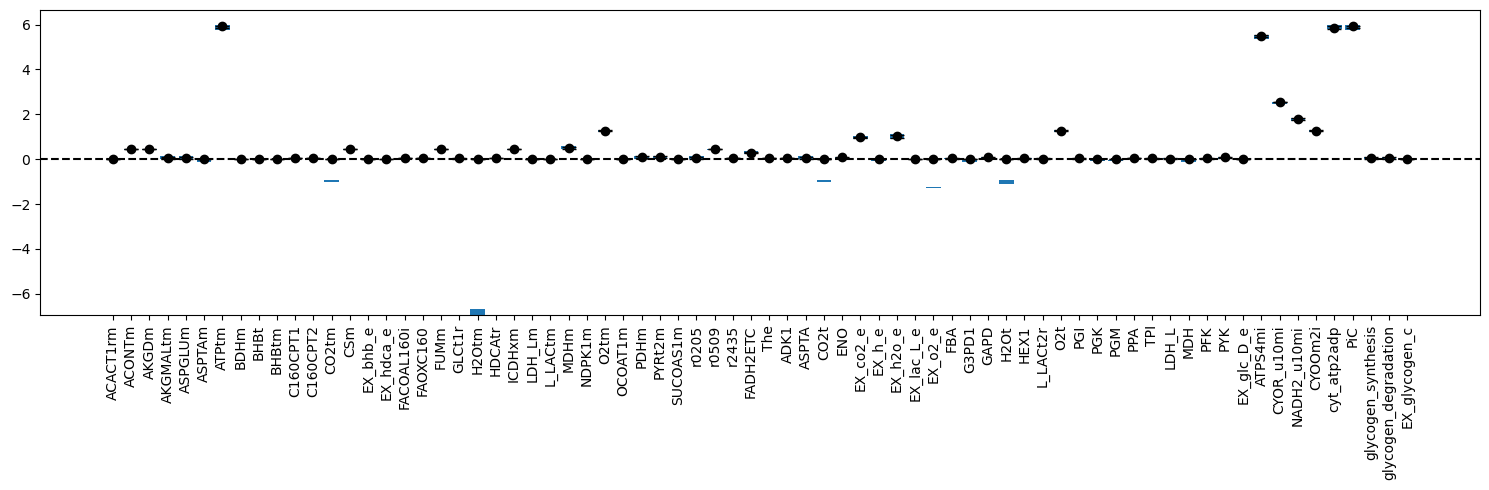

In [71]:
from pytfa.optim.variables import DeltaG
# PLot the TVA of the reaction fluxes
TVA = variability_analysis(continuous_model, kind='reaction')

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))

TVA['range'] = TVA.maximum - TVA.minimum
TVA['mid'] = (TVA.maximum + TVA.minimum) / 2

plt.bar(TVA.index, TVA.range, bottom=TVA.minimum)

LC_MEDIAN = sampling.median()[TVA.index]
LC_UQ = sampling.quantile(0.95)[TVA.index]
LC_LQ = sampling.quantile(0.05)[TVA.index]

plt.errorbar(TVA.index, LC_MEDIAN, yerr=[LC_MEDIAN - LC_LQ, LC_UQ - LC_MEDIAN], fmt='o', color='k', ecolor='k', capsize=5)

# Plot the 0 line 
plt.axhline(0, color='k', linestyle='--')

plt.xticks(np.arange(0,len(TVA.index)),  TVA.index, rotation=90)
plt.tight_layout()



In [72]:
TVA.loc[['cyt_atp2adp', 'glycogen_degradation','EX_glycogen_c']]

,minimum,maximum,range,mid
cyt_atp2adp,5.798083,5.998544,0.200461,5.898313
glycogen_degradation,0.010000,0.100000,0.090000,0.055000
EX_glycogen_c,-0.010000,-0.005000,0.005000,-0.007500


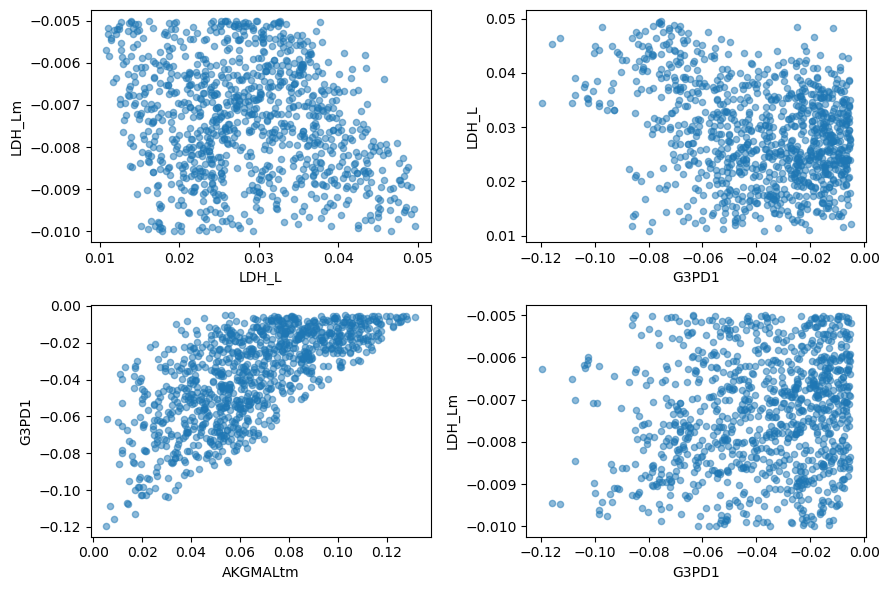

In [73]:
f, ax = plt.subplots(2,2, figsize=(9,6))

fluxes = sampling.iloc[:, 0:2*len(continuous_model.reactions):2] - sampling.iloc[:, 1:2*len(continuous_model.reactions)+1:2].values


fluxes.plot.scatter('LDH_L', 'LDH_Lm', alpha=0.5, ax =ax[0,0])
fluxes.plot.scatter('G3PD1', 'LDH_L', alpha=0.5, ax =ax[0,1])
fluxes.plot.scatter('AKGMALtm','G3PD1',  alpha=0.5, ax =ax[1,0])
fluxes.plot.scatter('G3PD1', 'LDH_Lm', alpha=0.5, ax =ax[1,1])



# for a in ax.flatten():
#     a.set_xlim(0,0.2)
#     a.set_ylim(0,0.2)

FVA.loc['PYRt2m']
plt.tight_layout()

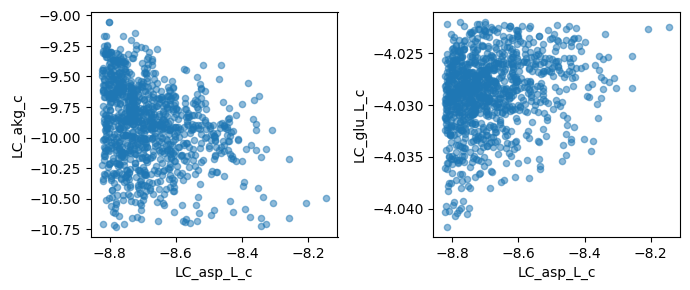

In [74]:
#Scatter for LC_pmtcoa_c and LC_pmtcoa_m
f, ax = plt.subplots(1,2, figsize=(7,3))

sampling.plot.scatter('LC_asp_L_c', 'LC_akg_c', alpha=0.5, ax =ax[0])
sampling.plot.scatter('LC_asp_L_c', 'LC_glu_L_c', alpha=0.5, ax =ax[1]) 

plt.tight_layout()
plt.show()

In [75]:
reduced_model.delta_gstd.L_LACtm

-1.0905599991066535 <= DGo_L_LACtm <= -1.0905599991066535

In [76]:
# Mtochondital charge balance 
charge_transport = {
    'CYOOm2i': -4.0,
    'CYOR_u10mi': -4.0,
    'NADH2_u10mi': -4.0,
    #'ATPS4mi': 4.0,
    #'ASPGLUm': 1.0,
    #'ATPtm': 1.0,
}


sampling['charge_balance'] = 0
for rxn_id, charge in charge_transport.items():
    print(rxn_id, charge , sampling[rxn_id].median())
    sampling['charge_balance'] += sampling[rxn_id] * charge

sampling['charge_balance'] = sampling['charge_balance'] * 1.2

CYOOm2i -4.0 1.2750863085299438
CYOR_u10mi -4.0 2.5501726170598875
NADH2_u10mi -4.0 1.7734954854359415


<Axes: ylabel='Frequency'>

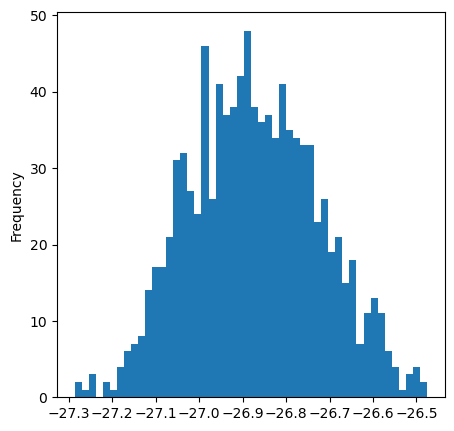

In [77]:
# Plor the charge balance
plt.figure(figsize=(5, 5))
sampling['charge_balance'].plot.hist(bins=50)

In [78]:
# # Make alist of all turn over rates that are conistantly low < 4.0 
# # exclude h2o and na1
# low_turnover = [m for m in turnover.columns[(turnover.abs().mean() < .1)] if not m.endswith("_e")] 

# # Plot the turnover rates as a boxplot
# f, ax = plt.subplots(figsize=(8, 5))
# sns.boxplot(data=turnover[low_turnover], ax=ax)
# plt.xticks(rotation=90)
# plt.show()

In [79]:
# Print all reaction with a deltaG_std  > +/- 10 kcal/mol
for rxn in continuous_model.reactions:
    if rxn.thermo['deltaGR'] > 5 and not rxn in continuous_model.boundary:
        print(rxn.id, rxn.reaction, rxn.thermo)

ACACT1rm 2.0 accoa_m <-- aacoa_m + coa_m {'isTrans': False, 'computed': True, 'deltaGR': 7.0560000000002105, 'deltaGRerr': 1.087366929789572}
ADK1 amp_c + atp_c + h_c --> 2.0 adp_c {'isTrans': False, 'computed': True, 'deltaGR': 10.24962080568946, 'deltaGRerr': 2}
FBA fdp_c --> dhap_c + g3p_c {'isTrans': False, 'computed': True, 'deltaGR': 5.604831372302954, 'deltaGRerr': 1.231339855604455}
PYK adp_c + h_c + pep_c --> atp_c + pyr_c {'isTrans': False, 'computed': True, 'deltaGR': 5.609472160844774, 'deltaGRerr': 0.654304974763298}
CYOR_u10mi 2.0 ficytC_m + 2.0 h_m + q10h2_m --> 2.0 focytC_m + 4.0 h_c + q10_m {'isTrans': True, 'computed': True, 'deltaGR': 6.5556627684669095, 'deltaGrxn': -11.643612983011053, 'deltaGRerr': 2.9916129428788074}
NADH2_u10mi 5.0 h_m + nadh_m + q10_m --> 4.0 h_c + nad_m + q10h2_m {'isTrans': True, 'computed': True, 'deltaGR': 22.84204887623445, 'deltaGrxn': -4.456864750982504, 'deltaGRerr': 3.07450548869245}
glycogen_synthesis atp_c + g6p_c --> adp_c + glycoge

In [80]:
# Print all reactions that use amp_c
for rxn in continuous_model.reactions:
    if 'amp_c' in [m.id for m in rxn.metabolites]:
        print(rxn.id, rxn.reaction, rxn.thermo)

FACOAL160i atp_c + coa_c + hdca_c --> amp_c + h_c + pmtcoa_c + ppi_c {'isTrans': False, 'computed': True, 'deltaGR': -21.838258329698704, 'deltaGRerr': 1.2316793413871974}
ADK1 amp_c + atp_c + h_c --> 2.0 adp_c {'isTrans': False, 'computed': True, 'deltaGR': 10.24962080568946, 'deltaGRerr': 2}


In [81]:
# Write the samples to a csv file
sampling.to_csv( redgem_file_name.replace('.json','_tfa_sampling.csv'), index=False)


In [82]:
# Save the continuous model
from pytfa.io.json import save_json_model
save_json_model(continuous_model, redgem_file_name.replace('.json', '_continuous.json'))

In [83]:
1/0

ZeroDivisionError: division by zero

In [ ]:
# This as an attempt not really makes sense
# dissipation = sum([ r.variable * reduced_model.reactions.get_by_id(r.id).reverse_variable 
#                - r.variable * reduced_model.reactions.get_by_id(r.id).forward_variable 
#                for r in reduced_model.delta_g])

# # Objective function
# reduced_model.objective = reduced_model.problem.Objective(dissipation, direction='min')

# reduced_model.solver.problem.parameters.optimalitytarget.set(3)

# reduced_model.optimize()

# Integrate fed state fluxes into the continous models

In [ ]:

# Relax the bounds but keep the directionality of dGs and fluxes
for reaction in continuous_model.reactions:
    if reaction.upper_bound > 0:
        reaction.bounds = (EPSILON_FLUX, 100)
    elif reaction.lower_bound < 0:
        reaction.bounds = (-100, -EPSILON_FLUX)

In [ ]:
# Flux constraints for the core model 
RER = 0.9
fraction_of_whole_body_o2 = 0.8
total_carbon_contribution_modeled = 0.80

o2_uptake = 2.0 * fraction_of_whole_body_o2 * total_carbon_contribution_modeled
co2_production = o2_uptake * RER 

# oxygen uptake about of redmuscle 80% of total oxygen uptake 2000 nmol/min/gBW -2 umol/min/gDW
# continuous_model.reactions.EX_o2_e.bounds = (-o2_uptake, -o2_uptake)
# Constrain the RET to about 0.8 of the total glucose uptake
continuous_model.reactions.EX_co2_e.bounds = (co2_production, co2_production)

#Add constraints for CO2 production in the core model of and glucose, lactate
glucose_direct_contribution = 0.23 / 6 / total_carbon_contribution_modeled 
lactate_direct_contribution = 0.22 / 3 / total_carbon_contribution_modeled
bhb_direct_contribution = 0.008 / 4 / total_carbon_contribution_modeled

# Note we should consider over all glucose oxidation in fed animals it seems that the direct contribution is under estimating 
# Glucose oxidation

continuous_model.reactions.EX_glc_D_e.bounds = (-co2_production * glucose_direct_contribution, -co2_production * glucose_direct_contribution)
continuous_model.reactions.EX_lac_L_e.bounds = (-co2_production * lactate_direct_contribution, -co2_production * lactate_direct_contribution)
continuous_model.reactions.EX_bhb_e.bounds = (-co2_production * bhb_direct_contribution, -co2_production * bhb_direct_contribution)
sol = continuous_model.optimize()

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [ ]:
# Run and plot the flux variablity analysis
FVA = variability_analysis(continuous_model, kind='reactions')

# Plot the fluxes as bars starting at min and ending at max
plt.figure(figsize=(15, 5))
FVA['range'] = FVA.maximum - FVA.minimum
FVA['mid'] = (FVA.maximum + FVA.minimum) / 2

plt.bar(FVA.index, FVA.range, bottom=FVA.minimum)
plt.scatter(FVA.index, FVA.mid, color='k', s=10)
plt.xticks(np.arange(len(FVA.index)), FVA.index, rotation=90)

plt.tight_layout()

fed_fluxes = FVA['mid']

2025-03-03 17:30:10,876 - thermomodel_Recon3thermoCurated - INFO - Beginning variability analysis for variable of type reactions
maximizing: 100%|██████████| 74/74 [00:00<00:00, 2204.47it/s]


Error in callback <function _draw_all_if_interactive at 0x7f87d9f4f430> (for post_execute):


ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True],
       fill_value=1e+20,
            dtype=float64)

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True,  True,  True,  True,  True,  True,  True,
                    True,  True],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1500x500 with 1 Axes>

In [ ]:
# Save the two mid flux profiles to a file
import pandas as pd 
df = pd.DataFrame([fasted_fluxes, fed_fluxes], index=['fasted','fed']).T
df.to_csv(redgem_file_name.replace('.json','_char_flux_profiles.csv'))

In [ ]:
# Compute the mean carbon flux from fed fed state predition 

mean_carbon_flux_fed = df.loc[:,'fed'].loc[rows].abs() * carbons
mean_carbon_flux_fasted = df.loc[:,'fasted'].loc[rows].abs() * carbons


# Add a column that accounts for 25% of the total flux and label it as 'other'
mean_carbon_flux_fed['other'] = mean_carbon_flux_fed.sum() * (1/0.80 - 1)
mean_carbon_flux_fasted['other'] = mean_carbon_flux_fasted.sum() * (1/0.80 - 1)

# A pie chart shoeing the distribution of the mean carbon flux:
fig, ax = plt.subplots(1,2)
mean_carbon_flux_fed.plot.pie(ax=ax[0], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)
mean_carbon_flux_fasted.plot.pie(ax=ax[1], subplots=True, figsize=(5,5), autopct='%1.1f%%', startangle=90)

rer_fed = - df.loc['EX_co2_e','fed'] / df.loc['EX_o2_e','fed']
rer_fasted = - df.loc['EX_co2_e','fasted'] / df.loc['EX_o2_e','fasted']

# Note that this RER is based on 80% oxygen consumptuion
ax[0].set_title(f"RER fed: {rer_fed:.2f}")
ax[1].set_title(f"RER fasted: {rer_fasted:.2f}")

/opt/homebrew/Caskroom/miniconda/base/envs/skimpy-env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3201: RuntimeWarning: invalid value encountered in true_divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 640x480 with 2 Axes>

In [ ]:
rer_fed = - df.loc['EX_co2_e','fed'] / df.loc['EX_o2_e','fed']

#### Sanity Checks on electron transports delta Gs

In [ ]:
# Compute the redox potential of the NADH/NAD+ couple in the model
# NAD+ + H+ + 2e- ->  NADH
dG = continuous_model.metabolites.nad_c.thermo['deltaGf_std'] + continuous_model.metabolites.h_c.thermo['deltaGf_std'] - continuous_model.metabolites.nadh_c.thermo['deltaGf_std']
# Convert to V
# ΔG=−nFE 
# 1kcal = 4.184e3 J
F = 96485/4.184e3
n = 2

E = dG / (n * F)
E

-0.3165590506296296

In [ ]:
# Compute the redox potential of the NADH/NAD+ couple in the model
# FAD + 2H+ + 2e- -> FADH2 (currently FAD is deprotonated so missing an H+)
dG = continuous_model.metabolites.fad_m.thermo['deltaGf_std'] + 3*continuous_model.metabolites.h_m.thermo['deltaGf_std'] - continuous_model.metabolites.fadh2_m.thermo['deltaGf_std']
# Convert to V
# ΔG=−nFE 
# 1kcal = 4.184e3 J
F = 96485/4.184e3
n = 2

E = dG / (n * F)
E

-0.19426133595895678

In [ ]:
# Compute the redox potential of the Cytochrome couple in the model
# cyt c (Fe3+) + e- -> cyt c (Fe2+)
dG = continuous_model.metabolites.ficytC_m.thermo['deltaGf_std']  - continuous_model.metabolites.focytC_m.thermo['deltaGf_std']
# Convert to V
# ΔG=−nFE 
# 1kcal = 4.184e3 J
F = 96485/4.184e3
n = 2

E = dG / (n * F)
E

0.12499999999999999

In [ ]:
# Compute the redox potential of the Q10/Q10H2 couple in the model
# Q10 + 2H+ + 2e- -> Q10H2 
dG = continuous_model.metabolites.q10_m.thermo['deltaGf_std'] + 2*continuous_model.metabolites.h_m.thermo['deltaGf_std'] - continuous_model.metabolites.q10h2_m.thermo['deltaGf_std']
# Convert to V
# ΔG=−nFE 
# 1kcal = 4.184e3 J
F = 96485/4.184e3
n = 2

E = dG / (n * F)
E

0.05724081463439945